## Bilinear CNN 

<b>REF:<br>
https://www.kaggle.com/code/rajeshbhat/fine-grained-image-classification-with-b-cnn-s/notebook <br>
https://wandb.ai/authors/bcnn/reports/Fine-Grained-Image-Classification-FGIC-with-B-CNNs---Vmlldzo0NDQ1Nzc <br>
https://www.youtube.com/watch?v=s437TvBuziM

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable
from tqdm import tqdm
import time


In [2]:
# if torch.cuda.is_available(): 
#  dev = "cuda:0" 
# else: 
# dev = "cpu" 
# device = torch.device(dev) 
# print(torch.cuda.get_device_name(device))

In [3]:

transform = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
BATCH_SIZE = 16
TRAIN_DATA_PATH = "C:/Users/gmita/Desktop/work_3_2_2565/onboard/pytorch_ver/Data/train"
VAL_DATA_PATH = "C:/Users/gmita/Desktop/work_3_2_2565/onboard/pytorch_ver/Data/val"
TEST_DATA_PATH = "C:/Users/gmita/Desktop/work_3_2_2565/onboard/pytorch_ver/Data/Test"

In [5]:
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,num_workers=0, shuffle=True,pin_memory=True)
                                    
val_data = torchvision.datasets.ImageFolder(root=VAL_DATA_PATH, transform=transform)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE,num_workers=0,  shuffle=True,pin_memory=True)
                                    
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE,num_workers=0,  shuffle=False,pin_memory=True)

Bilinear CNN

In [6]:
features = 2048
fmap_size = 7

class BCNN(nn.Module):
    
    def __init__(self, fine_tune=False):
        
        super(BCNN, self).__init__()
        
        resnet = models.resnet50(pretrained=True)
        
        # freezing parameters
        if not fine_tune:
            
            for param in resnet.parameters():
                param.requires_grad = False
        else:
            
            for param in resnet.parameters():
                param.requires_grad = True

        layers = list(resnet.children())[:-2]
        self.features = nn.Sequential(*layers) 
        
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(features ** 2, 4)
        
        self.sf = nn.Softmax(dim=1)
            
        # Initialize the fc layers.
        nn.init.xavier_normal_(self.fc.weight.data)
        
        if self.fc.bias is not None:
            torch.nn.init.constant_(self.fc.bias.data, val=0)
        
    def forward(self, x):
        
        ## N = bs
        N = x.size()[0]
        
        x = self.features(x)
        
        x = x.view(N, features, fmap_size ** 2)
        x = self.dropout(x)
        
        # Batch matrix multiplication
        x = torch.bmm(x, torch.transpose(x, 1, 2))/ (fmap_size ** 2) 
        x = x.view(N, features ** 2)
        x = torch.sqrt(x + 1e-5)
        x = nn.functional.normalize(x)
        

        x = self.fc(x)
#         x = self.bn(x)
#         x = self.rl(x)
#         x = self.fc0(x)
        x = self.sf(x)
        return x

In [7]:

def testAccuracy(model,loss_fn,dataset):
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    running_loss = 0.0
    
    with torch.no_grad():
        for data in dataset:
            images, labels = data
            # run the model on the test set to predict labels
#             model.cpu()
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
            loss = loss_fn(outputs, labels)
            running_loss += loss.item() 
            
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return accuracy , running_loss/ len(dataset)


def train(num_epochs,model,optimizer,loss_fn , traindata , validationdata ,name):

    # Define your execution device
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     print("The model will be running on", torch.cuda.get_device_name(device), "device")
    # Convert model parameters and buffers to CPU or Cuda
    best_val_loss = float("inf")
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0
        pbar = tqdm(total=len(traindata), desc=f"Epoch {epoch+1}/{num_epochs}", position=0, leave=True)
        for i, (images, labels) in enumerate(traindata, 0):
            
            # get the inputs
            images = Variable(images)
            labels = Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
#             model.to(device)
            # print(images.dim())
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            pbar.update(1)
            pbar.set_postfix({'Loss': running_loss / len(traindata)})
        pbar.close()
        end_time = time.time()
        accuracy , loss  = testAccuracy(model,loss_fn,validationdata)
        print('For epoch {}, the test accuracy over the whole test set is {}% and loss {}'.format(epoch+1, accuracy , loss))
        if loss < best_val_loss:
            best_val_loss = loss
            torch.save(model.state_dict(), name)
    end_time = time.time()
    end_time = time.time()
    print("Training complete!")
    print("Total training time: {:.2f} seconds".format(end_time - start_time))

In [8]:

# from module import train , testAccuracy

model = BCNN().cpu()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(30,model,optimizer,criterion,train_loader,val_loader,"BCNN.pt")



C:\Users\gmita\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\gmita\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/30: 100%|███████████████████████████████████████████████████████████| 88/88 [02:44<00:00,  1.87s/it, Loss=1.33]


For epoch 1, the test accuracy over the whole test set is 61.5% and loss 1.1596242693754344


Epoch 2/30: 100%|███████████████████████████████████████████████████████████| 88/88 [02:28<00:00,  1.69s/it, Loss=1.13]


For epoch 2, the test accuracy over the whole test set is 70.0% and loss 1.0733333826065063


Epoch 3/30: 100%|██████████████████████████████████████████████████████████| 88/88 [02:31<00:00,  1.73s/it, Loss=0.956]


For epoch 3, the test accuracy over the whole test set is 93.0% and loss 0.8676136961350074


Epoch 4/30: 100%|██████████████████████████████████████████████████████████| 88/88 [02:33<00:00,  1.75s/it, Loss=0.873]


For epoch 4, the test accuracy over the whole test set is 94.0% and loss 0.8397626005686246


Epoch 5/30: 100%|██████████████████████████████████████████████████████████| 88/88 [02:32<00:00,  1.74s/it, Loss=0.839]


For epoch 5, the test accuracy over the whole test set is 95.5% and loss 0.8362339322383587


Epoch 6/30: 100%|██████████████████████████████████████████████████████████| 88/88 [02:32<00:00,  1.73s/it, Loss=0.826]


For epoch 6, the test accuracy over the whole test set is 96.5% and loss 0.8129161779697125


Epoch 7/30: 100%|██████████████████████████████████████████████████████████| 88/88 [02:32<00:00,  1.73s/it, Loss=0.816]


For epoch 7, the test accuracy over the whole test set is 95.5% and loss 0.8150448799133301


Epoch 8/30: 100%|██████████████████████████████████████████████████████████| 88/88 [02:31<00:00,  1.72s/it, Loss=0.809]


For epoch 8, the test accuracy over the whole test set is 96.5% and loss 0.8050435414681067


Epoch 9/30: 100%|██████████████████████████████████████████████████████████| 88/88 [02:31<00:00,  1.72s/it, Loss=0.804]


For epoch 9, the test accuracy over the whole test set is 96.5% and loss 0.8035018031413739


Epoch 10/30: 100%|█████████████████████████████████████████████████████████| 88/88 [02:31<00:00,  1.72s/it, Loss=0.799]


For epoch 10, the test accuracy over the whole test set is 96.5% and loss 0.8031176741306598


Epoch 11/30: 100%|█████████████████████████████████████████████████████████| 88/88 [02:31<00:00,  1.72s/it, Loss=0.795]


For epoch 11, the test accuracy over the whole test set is 95.5% and loss 0.8148531592809237


Epoch 12/30: 100%|█████████████████████████████████████████████████████████| 88/88 [02:31<00:00,  1.72s/it, Loss=0.795]


For epoch 12, the test accuracy over the whole test set is 96.5% and loss 0.7996974587440491


Epoch 13/30: 100%|█████████████████████████████████████████████████████████| 88/88 [02:31<00:00,  1.73s/it, Loss=0.793]


For epoch 13, the test accuracy over the whole test set is 94.5% and loss 0.8057191830414993


Epoch 14/30: 100%|█████████████████████████████████████████████████████████| 88/88 [02:31<00:00,  1.73s/it, Loss=0.786]


For epoch 14, the test accuracy over the whole test set is 93.0% and loss 0.8305333990317124


Epoch 15/30: 100%|█████████████████████████████████████████████████████████| 88/88 [02:31<00:00,  1.72s/it, Loss=0.777]


For epoch 15, the test accuracy over the whole test set is 96.0% and loss 0.7976883879074683


Epoch 16/30: 100%|█████████████████████████████████████████████████████████| 88/88 [02:31<00:00,  1.73s/it, Loss=0.778]


For epoch 16, the test accuracy over the whole test set is 94.5% and loss 0.8071528719021723


Epoch 17/30: 100%|█████████████████████████████████████████████████████████| 88/88 [02:32<00:00,  1.74s/it, Loss=0.773]


For epoch 17, the test accuracy over the whole test set is 95.5% and loss 0.794767962052272


Epoch 18/30: 100%|█████████████████████████████████████████████████████████| 88/88 [02:28<00:00,  1.69s/it, Loss=0.766]


For epoch 18, the test accuracy over the whole test set is 93.0% and loss 0.8268395708157465


Epoch 19/30: 100%|█████████████████████████████████████████████████████████| 88/88 [02:27<00:00,  1.68s/it, Loss=0.767]


For epoch 19, the test accuracy over the whole test set is 95.5% and loss 0.7953377549464886


Epoch 20/30: 100%|█████████████████████████████████████████████████████████| 88/88 [02:26<00:00,  1.67s/it, Loss=0.765]


For epoch 20, the test accuracy over the whole test set is 96.0% and loss 0.794037415431096


Epoch 21/30: 100%|█████████████████████████████████████████████████████████| 88/88 [02:27<00:00,  1.67s/it, Loss=0.761]


For epoch 21, the test accuracy over the whole test set is 95.0% and loss 0.8025176662665147


Epoch 22/30: 100%|█████████████████████████████████████████████████████████| 88/88 [02:27<00:00,  1.68s/it, Loss=0.759]


For epoch 22, the test accuracy over the whole test set is 95.0% and loss 0.7917643464528598


Epoch 23/30: 100%|█████████████████████████████████████████████████████████| 88/88 [02:26<00:00,  1.67s/it, Loss=0.758]


For epoch 23, the test accuracy over the whole test set is 95.0% and loss 0.7921630373367896


Epoch 24/30: 100%|█████████████████████████████████████████████████████████| 88/88 [02:26<00:00,  1.66s/it, Loss=0.757]


For epoch 24, the test accuracy over the whole test set is 95.5% and loss 0.7958819591082059


Epoch 25/30: 100%|█████████████████████████████████████████████████████████| 88/88 [02:26<00:00,  1.66s/it, Loss=0.756]


For epoch 25, the test accuracy over the whole test set is 95.0% and loss 0.7942162568752582


Epoch 26/30: 100%|█████████████████████████████████████████████████████████| 88/88 [02:26<00:00,  1.67s/it, Loss=0.756]


For epoch 26, the test accuracy over the whole test set is 96.0% and loss 0.7943724714792691


Epoch 27/30: 100%|█████████████████████████████████████████████████████████| 88/88 [02:26<00:00,  1.66s/it, Loss=0.755]


For epoch 27, the test accuracy over the whole test set is 95.0% and loss 0.7932176269017733


Epoch 28/30: 100%|█████████████████████████████████████████████████████████| 88/88 [02:25<00:00,  1.65s/it, Loss=0.755]


For epoch 28, the test accuracy over the whole test set is 95.0% and loss 0.7888998068295993


Epoch 29/30: 100%|█████████████████████████████████████████████████████████| 88/88 [02:25<00:00,  1.65s/it, Loss=0.754]


For epoch 29, the test accuracy over the whole test set is 95.5% and loss 0.790013157404386


Epoch 30/30: 100%|█████████████████████████████████████████████████████████| 88/88 [02:25<00:00,  1.65s/it, Loss=0.755]


For epoch 30, the test accuracy over the whole test set is 95.5% and loss 0.7878499764662522
Training complete!
Total training time: 5106.35 seconds


In [9]:

state_dict = torch.load("BCNN.pt")
model.load_state_dict(state_dict)

accuracy , loss  = testAccuracy(model,criterion,test_loader)
print(f"Test accuracy = {accuracy}%")


Test accuracy = 95.53349875930522%


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

# Create a list to store the incorrectly predicted images
wrong_images = []

# Create a list to store the true labels of the incorrectly predicted images
true_labels = []

# Create a list to store the predicted labels of the incorrectly predicted images
pred_labels = []

# for classification report
y_pred = []
y_true = []

# Iterate over the test dataset
for inputs, labels in test_loader:
    # Move the inputs and labels to the device

    # Forward pass
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    y_pred.extend(preds.cpu().numpy())
    y_true.extend(labels.cpu().numpy())
    # Check if the predicted labels match the true labels
    wrong_idx = torch.where(preds != labels)[0]

    # Add the incorrectly predicted images to the list
    for idx in wrong_idx:
        wrong_images.append(inputs[idx].cpu())
        true_labels.append(labels[idx].cpu().item())
        pred_labels.append(preds[idx].cpu().item())

In [11]:
from sklearn.metrics import classification_report

Class_name = test_loader.dataset.classes
report = classification_report(y_true, y_pred, target_names=Class_name)
print(report)

                           precision    recall  f1-score   support

      Curved Mayo Scissor       0.90      0.95      0.93       104
                  Scalpel       0.99      1.00      1.00       111
Straight Dissection Clamp       0.98      0.99      0.98        83
    Straight Mayo Scissor       0.96      0.89      0.92       105

                 accuracy                           0.96       403
                macro avg       0.96      0.96      0.96       403
             weighted avg       0.96      0.96      0.96       403



C:\Users\gmita\AppData\Local\Temp\ipykernel_17356\106989277.py:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  wrong_images = np.array(wrong_images,dtype=object)


Wrong indice amount :  18


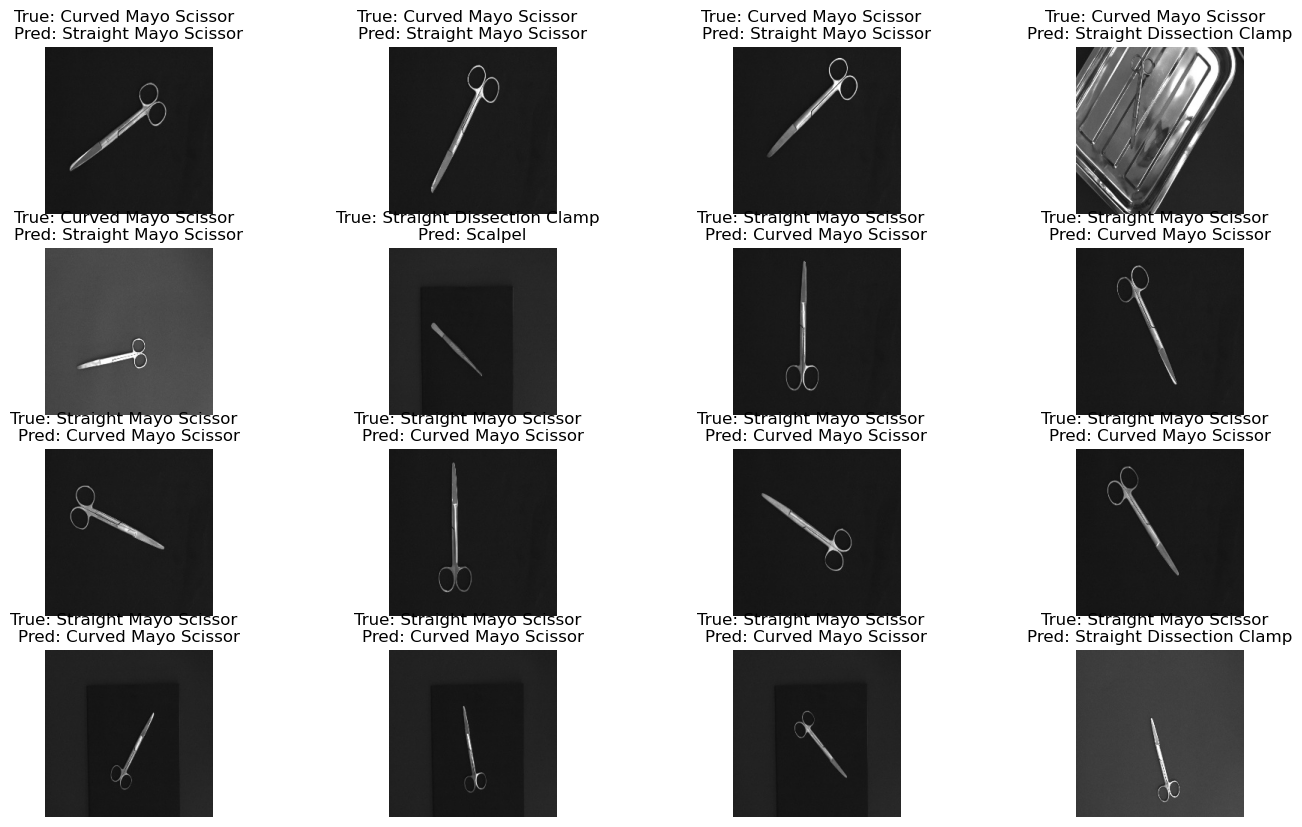

In [12]:

# Convert the lists to NumPy arrays
wrong_images = np.array(wrong_images,dtype=object)
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Create a grid of subplots to display the images
fig, axs = plt.subplots(4, 4, figsize=(17, 10))
axs = axs.flatten()
Class_name = test_loader.dataset.classes
print("Wrong indice amount : " , len(wrong_images))
# Iterate over the subplots
for i, ax in enumerate(axs):
    # Display the image
    ax.imshow(wrong_images[i].transpose(0, 2).transpose(0, 1))
    ax.axis('off')
    ax.imshow(wrong_images[i].transpose(0, 2).transpose(0, 1))
    ax.axis('off')
    # Set the title to the true and predicted labels
    ax.set_title(f'True: {Class_name[true_labels[i]]}  \nPred: {Class_name[pred_labels[i]]}')

    # Break the loop if we have displayed 16 images
    if i == len(wrong_images) - 1:
        break

# Show the plot
plt.show()

<b>summary</b><br>
1. Model can classify class 0,3 (Curved and Straight Mayo scissor) better than ResNet50 and SeReNet50 but it’s F1-score of 2 scissor as good as VGG16. <br>
2. Training Bilinear model using expensive computational and requires large memory.<br>
3. Due to models using 2 ResNet50 models, the feature maps can be redundant.<br>
4. some information in the images to be lost or disappear when they are resized from 640x480 to 224x224. Resizing an image involves changing its resolution and dimensions, which can result in a loss of some details and information present in the original image not only in this model.
